In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 92)
(631390, 1)
validation
(74368, 92)
(74368, 1)
test
(85358, 92)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 784385 (2.99 MB)


Trainable params: 784385 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:08 - loss: 0.0148 - STD: 2.4769e-05 - MAE: 0.1052

 7/64 [==>...........................] - ETA: 0s - loss: 0.0139 - STD: 2.5846e-05 - MAE: 0.0903  

13/64 [=====>........................] - ETA: 0s - loss: 0.0127 - STD: 4.5142e-05 - MAE: 0.0872

20/64 [========>.....................] - ETA: 0s - loss: 0.0119 - STD: 6.6150e-05 - MAE: 0.0846

27/64 [===========>..................] - ETA: 0s - loss: 0.0115 - STD: 8.5431e-05 - MAE: 0.0830

31/64 [=============>................] - ETA: 0s - loss: 0.0114 - STD: 9.5797e-05 - MAE: 0.0823

38/64 [================>.............] - ETA: 0s - loss: 0.0111 - STD: 1.1572e-04 - MAE: 0.0817

45/64 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 1.3555e-04 - MAE: 0.0811

52/64 [=======================>......] - ETA: 0s - loss: 0.0108 - STD: 1.5689e-04 - MAE: 0.0807

59/64 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 1.8138e-04 - MAE: 0.0804

64/64 [==============================] - 3s 25ms/step - loss: 0.0106 - STD: 2.0008e-04 - MAE: 0.0802 - val_loss: 0.0094 - val_STD: 3.8232e-04 - val_MAE: 0.0762


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0098 - STD: 4.6401e-04 - MAE: 0.0775

 8/64 [==>...........................] - ETA: 0s - loss: 0.0098 - STD: 5.1678e-04 - MAE: 0.0776

14/64 [=====>........................] - ETA: 0s - loss: 0.0099 - STD: 5.6965e-04 - MAE: 0.0778

21/64 [========>.....................] - ETA: 0s - loss: 0.0099 - STD: 6.4174e-04 - MAE: 0.0777

28/64 [============>.................] - ETA: 0s - loss: 0.0098 - STD: 7.3467e-04 - MAE: 0.0776

35/64 [===============>..............] - ETA: 0s - loss: 0.0098 - STD: 8.5256e-04 - MAE: 0.0777

42/64 [==================>...........] - ETA: 0s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0775    

49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0774

55/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0774

61/64 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773

64/64 [==============================] - 1s 10ms/step - loss: 0.0097 - STD: 0.0020 - MAE: 0.0772 - val_loss: 0.0086 - val_STD: 0.0061 - val_MAE: 0.0733


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0094 - STD: 0.0075 - MAE: 0.0760

 8/64 [==>...........................] - ETA: 0s - loss: 0.0090 - STD: 0.0098 - MAE: 0.0750

15/64 [======>.......................] - ETA: 0s - loss: 0.0087 - STD: 0.0133 - MAE: 0.0740

22/64 [=========>....................] - ETA: 0s - loss: 0.0084 - STD: 0.0185 - MAE: 0.0723

29/64 [============>.................] - ETA: 0s - loss: 0.0080 - STD: 0.0250 - MAE: 0.0705

36/64 [===============>..............] - ETA: 0s - loss: 0.0078 - STD: 0.0312 - MAE: 0.0691

43/64 [===================>..........] - ETA: 0s - loss: 0.0077 - STD: 0.0353 - MAE: 0.0681

50/64 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0376 - MAE: 0.0674

57/64 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0394 - MAE: 0.0669

64/64 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.0412 - MAE: 0.0664

64/64 [==============================] - 1s 9ms/step - loss: 0.0074 - STD: 0.0412 - MAE: 0.0664 - val_loss: 0.0057 - val_STD: 0.0472 - val_MAE: 0.0592


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0568 - MAE: 0.0624

 8/64 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0562 - MAE: 0.0623

15/64 [======>.......................] - ETA: 0s - loss: 0.0067 - STD: 0.0556 - MAE: 0.0622

22/64 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0554 - MAE: 0.0623

28/64 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0554 - MAE: 0.0622

35/64 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0556 - MAE: 0.0622

42/64 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0558 - MAE: 0.0622

49/64 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0559 - MAE: 0.0622

56/64 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0559 - MAE: 0.0622

62/64 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0559 - MAE: 0.0622

64/64 [==============================] - 1s 9ms/step - loss: 0.0067 - STD: 0.0559 - MAE: 0.0622 - val_loss: 0.0056 - val_STD: 0.0468 - val_MAE: 0.0586


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0564 - MAE: 0.0617

 7/64 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0563 - MAE: 0.0615

13/64 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0565 - MAE: 0.0620

19/64 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0563 - MAE: 0.0616

25/64 [==========>...................] - ETA: 0s - loss: 0.0067 - STD: 0.0563 - MAE: 0.0618

32/64 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0564 - MAE: 0.0618

38/64 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0566 - MAE: 0.0618

45/64 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0567 - MAE: 0.0618

52/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0566 - MAE: 0.0618

59/64 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0566 - MAE: 0.0618

64/64 [==============================] - 1s 9ms/step - loss: 0.0067 - STD: 0.0567 - MAE: 0.0617 - val_loss: 0.0057 - val_STD: 0.0480 - val_MAE: 0.0602


Epoch 6/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0578 - MAE: 0.0630

 7/64 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0569 - MAE: 0.0616

14/64 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0569 - MAE: 0.0618

21/64 [========>.....................] - ETA: 0s - loss: 0.0067 - STD: 0.0570 - MAE: 0.0618

27/64 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0570 - MAE: 0.0618

34/64 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0571 - MAE: 0.0617

41/64 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0571 - MAE: 0.0616

48/64 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0570 - MAE: 0.0616

55/64 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0570 - MAE: 0.0616

62/64 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0571 - MAE: 0.0615

64/64 [==============================] - 1s 9ms/step - loss: 0.0066 - STD: 0.0571 - MAE: 0.0615 - val_loss: 0.0055 - val_STD: 0.0477 - val_MAE: 0.0578


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0576 - MAE: 0.0608

 7/64 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0580 - MAE: 0.0611

13/64 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0582 - MAE: 0.0612

19/64 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0579 - MAE: 0.0612

26/64 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0577 - MAE: 0.0613

33/64 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0577 - MAE: 0.0612

40/64 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0577 - MAE: 0.0612

47/64 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0612

54/64 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0612

61/64 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0611

64/64 [==============================] - 1s 9ms/step - loss: 0.0065 - STD: 0.0578 - MAE: 0.0612 - val_loss: 0.0056 - val_STD: 0.0489 - val_MAE: 0.0591


Epoch 8/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0592 - MAE: 0.0623

 7/64 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0584 - MAE: 0.0615

14/64 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0581 - MAE: 0.0614

21/64 [========>.....................] - ETA: 0s - loss: 0.0065 - STD: 0.0582 - MAE: 0.0613

28/64 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0612

35/64 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0611

42/64 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0610

49/64 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0582 - MAE: 0.0610

56/64 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0609

63/64 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0609

64/64 [==============================] - 1s 9ms/step - loss: 0.0065 - STD: 0.0583 - MAE: 0.0609 - val_loss: 0.0055 - val_STD: 0.0486 - val_MAE: 0.0579


Epoch 9/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0580 - MAE: 0.0619

 7/64 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0612

13/64 [=====>........................] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0611

20/64 [========>.....................] - ETA: 0s - loss: 0.0065 - STD: 0.0583 - MAE: 0.0612

27/64 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0611

34/64 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0578 - MAE: 0.0612

41/64 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0579 - MAE: 0.0611

47/64 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0581 - MAE: 0.0611

53/64 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0582 - MAE: 0.0610

59/64 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0582 - MAE: 0.0609

64/64 [==============================] - 1s 10ms/step - loss: 0.0065 - STD: 0.0582 - MAE: 0.0609 - val_loss: 0.0054 - val_STD: 0.0489 - val_MAE: 0.0575


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0589 - MAE: 0.0616

 6/64 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0587 - MAE: 0.0607

12/64 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0592 - MAE: 0.0605

19/64 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0592 - MAE: 0.0608

26/64 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0589 - MAE: 0.0607

32/64 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0588 - MAE: 0.0607

39/64 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0587 - MAE: 0.0607

45/64 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0588 - MAE: 0.0606

52/64 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0589 - MAE: 0.0606

59/64 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0589 - MAE: 0.0606

64/64 [==============================] - 1s 10ms/step - loss: 0.0064 - STD: 0.0589 - MAE: 0.0606 - val_loss: 0.0053 - val_STD: 0.0488 - val_MAE: 0.0567


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0601

 7/64 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0584 - MAE: 0.0608

14/64 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0587 - MAE: 0.0608

21/64 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0588 - MAE: 0.0606

28/64 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0588 - MAE: 0.0607

35/64 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0587 - MAE: 0.0607

42/64 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0587 - MAE: 0.0608

49/64 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0588 - MAE: 0.0607

56/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0588 - MAE: 0.0607

63/64 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0589 - MAE: 0.0606

64/64 [==============================] - 1s 9ms/step - loss: 0.0064 - STD: 0.0589 - MAE: 0.0606 - val_loss: 0.0054 - val_STD: 0.0507 - val_MAE: 0.0577


Epoch 12/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0608 - MAE: 0.0613

 7/64 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0595 - MAE: 0.0601

14/64 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0603

21/64 [========>.....................] - ETA: 0s - loss: 0.0063 - STD: 0.0595 - MAE: 0.0603

27/64 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0596 - MAE: 0.0602

34/64 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0596 - MAE: 0.0603

41/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0595 - MAE: 0.0603

48/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0603

55/64 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0603

62/64 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0593 - MAE: 0.0603

64/64 [==============================] - 1s 9ms/step - loss: 0.0064 - STD: 0.0593 - MAE: 0.0603 - val_loss: 0.0053 - val_STD: 0.0507 - val_MAE: 0.0575


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0605 - MAE: 0.0608

 7/64 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0599 - MAE: 0.0603

14/64 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0602 - MAE: 0.0605

21/64 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0599 - MAE: 0.0605

28/64 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0597 - MAE: 0.0605

35/64 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0595 - MAE: 0.0605

42/64 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0593 - MAE: 0.0605

49/64 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0593 - MAE: 0.0605

56/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0594 - MAE: 0.0604

63/64 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0595 - MAE: 0.0604

64/64 [==============================] - 1s 10ms/step - loss: 0.0064 - STD: 0.0595 - MAE: 0.0604 - val_loss: 0.0052 - val_STD: 0.0493 - val_MAE: 0.0559


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0063 - STD: 0.0596 - MAE: 0.0596

 7/64 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0590 - MAE: 0.0604

14/64 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0591 - MAE: 0.0605

21/64 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0594 - MAE: 0.0606

28/64 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0592 - MAE: 0.0607

35/64 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0591 - MAE: 0.0607

41/64 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0591 - MAE: 0.0605

47/64 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0592 - MAE: 0.0605

53/64 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0593 - MAE: 0.0604

60/64 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0603

64/64 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0593 - MAE: 0.0603 - val_loss: 0.0053 - val_STD: 0.0509 - val_MAE: 0.0576


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0613 - MAE: 0.0616

 7/64 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0597 - MAE: 0.0601

14/64 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0599 - MAE: 0.0606

21/64 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0598 - MAE: 0.0605

28/64 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0596 - MAE: 0.0604

34/64 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0597 - MAE: 0.0604

40/64 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0597 - MAE: 0.0604

47/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0597 - MAE: 0.0603

54/64 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0596 - MAE: 0.0602

61/64 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0596 - MAE: 0.0601

64/64 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0596 - MAE: 0.0601 - val_loss: 0.0052 - val_STD: 0.0498 - val_MAE: 0.0555


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0598 - MAE: 0.0597

 8/64 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0603 - MAE: 0.0597

15/64 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0598

21/64 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0597

28/64 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0597

35/64 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0597

42/64 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0605 - MAE: 0.0597

48/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0597

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0597

61/64 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0603 - MAE: 0.0597

64/64 [==============================] - 1s 9ms/step - loss: 0.0062 - STD: 0.0603 - MAE: 0.0597 - val_loss: 0.0055 - val_STD: 0.0531 - val_MAE: 0.0597


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0638 - MAE: 0.0626

 8/64 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0593 - MAE: 0.0606

15/64 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0590 - MAE: 0.0608

21/64 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0590 - MAE: 0.0605

27/64 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0603

33/64 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0601

40/64 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0597 - MAE: 0.0600

46/64 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0598 - MAE: 0.0599

53/64 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0599 - MAE: 0.0599

59/64 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0599 - MAE: 0.0598

64/64 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0599 - MAE: 0.0598 - val_loss: 0.0052 - val_STD: 0.0518 - val_MAE: 0.0570


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0619 - MAE: 0.0601

 8/64 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0607 - MAE: 0.0594

15/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0593

22/64 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0608 - MAE: 0.0593

29/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0592

35/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0593

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0593

47/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0607 - MAE: 0.0593

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0608 - MAE: 0.0594

60/64 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0607 - MAE: 0.0594

64/64 [==============================] - 1s 9ms/step - loss: 0.0062 - STD: 0.0608 - MAE: 0.0594 - val_loss: 0.0051 - val_STD: 0.0516 - val_MAE: 0.0557


Epoch 19/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0604 - MAE: 0.0604

 7/64 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0610 - MAE: 0.0597

14/64 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0601 - MAE: 0.0597

21/64 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0595 - MAE: 0.0604

28/64 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0591 - MAE: 0.0605

35/64 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0590 - MAE: 0.0605

42/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0603

49/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0596 - MAE: 0.0601

56/64 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0598 - MAE: 0.0600

63/64 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0599 - MAE: 0.0599

64/64 [==============================] - 1s 9ms/step - loss: 0.0063 - STD: 0.0599 - MAE: 0.0599 - val_loss: 0.0051 - val_STD: 0.0517 - val_MAE: 0.0565


Epoch 20/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0593

 7/64 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0593

14/64 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0603 - MAE: 0.0595

20/64 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0605 - MAE: 0.0595

27/64 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0605 - MAE: 0.0595

34/64 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0605 - MAE: 0.0596

41/64 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0605 - MAE: 0.0595

48/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0595

55/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0603 - MAE: 0.0595

62/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0595

64/64 [==============================] - 1s 9ms/step - loss: 0.0062 - STD: 0.0604 - MAE: 0.0595 - val_loss: 0.0050 - val_STD: 0.0504 - val_MAE: 0.0547


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0601 - MAE: 0.0589

 8/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0590

15/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0588

22/64 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0589

29/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0589

36/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0590

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0590

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0589

55/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0589

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0589

64/64 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0611 - MAE: 0.0589 - val_loss: 0.0052 - val_STD: 0.0531 - val_MAE: 0.0571


Epoch 22/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0627 - MAE: 0.0610

 8/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0593

15/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0591

22/64 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0590

29/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0589

36/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0590

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0590

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0590

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0590

63/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0589

64/64 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0613 - MAE: 0.0589 - val_loss: 0.0050 - val_STD: 0.0511 - val_MAE: 0.0544


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0602 - MAE: 0.0587

 8/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0591

15/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0590

21/64 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0616 - MAE: 0.0590

27/64 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0617 - MAE: 0.0589

34/64 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0589

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0589

48/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0588

55/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0588

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0590

64/64 [==============================] - 1s 9ms/step - loss: 0.0062 - STD: 0.0612 - MAE: 0.0591 - val_loss: 0.0053 - val_STD: 0.0431 - val_MAE: 0.0537


Epoch 24/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0069 - STD: 0.0506 - MAE: 0.0604

 8/64 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0556 - MAE: 0.0600

14/64 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0572 - MAE: 0.0598

21/64 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0586 - MAE: 0.0594

28/64 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0592

35/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0596 - MAE: 0.0591

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0599 - MAE: 0.0590

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0590

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0590

63/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0590

64/64 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0605 - MAE: 0.0590 - val_loss: 0.0050 - val_STD: 0.0524 - val_MAE: 0.0559


Epoch 25/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0593

 8/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0600 - MAE: 0.0592

15/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0591

22/64 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0589

29/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0588

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0587

43/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0586

50/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0587

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0587

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0587

64/64 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0614 - MAE: 0.0587 - val_loss: 0.0050 - val_STD: 0.0533 - val_MAE: 0.0553


Epoch 26/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0632 - MAE: 0.0582

 7/64 [==>...........................] - ETA: 0s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0581

13/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0583

20/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0584

27/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0585

34/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0585

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0585

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0585

55/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0585

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0585

64/64 [==============================] - 1s 10ms/step - loss: 0.0060 - STD: 0.0620 - MAE: 0.0584 - val_loss: 0.0049 - val_STD: 0.0520 - val_MAE: 0.0544


Epoch 27/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0580

 7/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0611 - MAE: 0.0583

14/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0584

21/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0584

27/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0583

34/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0583

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0584

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0584

53/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0584

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0584

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0620 - MAE: 0.0584 - val_loss: 0.0049 - val_STD: 0.0534 - val_MAE: 0.0546


Epoch 28/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0580

 8/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0621 - MAE: 0.0587

15/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0622 - MAE: 0.0586

22/64 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0623 - MAE: 0.0586

28/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0622 - MAE: 0.0585

35/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0585

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0585

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0584

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0584

63/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0584

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0620 - MAE: 0.0584 - val_loss: 0.0048 - val_STD: 0.0520 - val_MAE: 0.0535


Epoch 29/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0601 - MAE: 0.0579

 7/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0623 - MAE: 0.0584

14/64 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0621 - MAE: 0.0584

21/64 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0620 - MAE: 0.0584

28/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0618 - MAE: 0.0587

35/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0587

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0586

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0585

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0616 - MAE: 0.0585

63/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0616 - MAE: 0.0585

64/64 [==============================] - 1s 9ms/step - loss: 0.0061 - STD: 0.0616 - MAE: 0.0585 - val_loss: 0.0052 - val_STD: 0.0567 - val_MAE: 0.0572


Epoch 30/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0658 - MAE: 0.0603

 8/64 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0623 - MAE: 0.0591

14/64 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0616 - MAE: 0.0586

21/64 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0617 - MAE: 0.0584

28/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0619 - MAE: 0.0585

34/64 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0619 - MAE: 0.0585

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0619 - MAE: 0.0585

48/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0618 - MAE: 0.0585

54/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0618 - MAE: 0.0585

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0618 - MAE: 0.0585

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0618 - MAE: 0.0584 - val_loss: 0.0050 - val_STD: 0.0547 - val_MAE: 0.0558


Epoch 31/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0063 - STD: 0.0633 - MAE: 0.0600

 8/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0583

14/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0584

20/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0583

26/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0582

33/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0583

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0582

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0582

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0583

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0583

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0620 - MAE: 0.0582 - val_loss: 0.0049 - val_STD: 0.0532 - val_MAE: 0.0539


Epoch 32/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0580

 8/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0582

15/64 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0581

22/64 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0580

29/64 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0581

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0581

43/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0580

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0580

57/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0580

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0580

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0623 - MAE: 0.0580 - val_loss: 0.0049 - val_STD: 0.0554 - val_MAE: 0.0541


Epoch 33/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0063 - STD: 0.0637 - MAE: 0.0595

 7/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0578

14/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

21/64 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0579

28/64 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0580

35/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0580

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0581

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0581

55/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0583

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0583

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0619 - MAE: 0.0583 - val_loss: 0.0048 - val_STD: 0.0540 - val_MAE: 0.0532


Epoch 34/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0625 - MAE: 0.0576

 8/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0633 - MAE: 0.0579

14/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0581

21/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0580

28/64 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0579

35/64 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0579

42/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0578

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0579

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0579

63/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579 - val_loss: 0.0049 - val_STD: 0.0546 - val_MAE: 0.0545


Epoch 35/10000


 1/64 [..............................] - ETA: 0s - loss: 0.0059 - STD: 0.0638 - MAE: 0.0582

 7/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0578

13/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0578

20/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

27/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0581

33/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0581

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0580

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0580

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0580

61/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579 - val_loss: 0.0049 - val_STD: 0.0553 - val_MAE: 0.0541


Epoch 36/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0636 - MAE: 0.0582

 8/64 [==>...........................] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0577

15/64 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0577

22/64 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0578

29/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0578

36/64 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0579

43/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

57/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0579

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0579

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0626 - MAE: 0.0579 - val_loss: 0.0049 - val_STD: 0.0551 - val_MAE: 0.0548


Epoch 37/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0583

 8/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0579

15/64 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0631 - MAE: 0.0578

21/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0579

28/64 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0580

35/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0580

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0581

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0581

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0580

63/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0579

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0623 - MAE: 0.0580 - val_loss: 0.0048 - val_STD: 0.0527 - val_MAE: 0.0537


Epoch 38/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0605 - MAE: 0.0569

 7/64 [==>...........................] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0577

13/64 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0577

19/64 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0577

26/64 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0577

33/64 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0577

40/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0577

47/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0577

53/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0578

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0579

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0623 - MAE: 0.0579 - val_loss: 0.0048 - val_STD: 0.0538 - val_MAE: 0.0532


Epoch 39/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0571

 7/64 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0626 - MAE: 0.0581

13/64 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0620 - MAE: 0.0585

19/64 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0618 - MAE: 0.0584

26/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0581

33/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0580

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0580

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0579

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0579

61/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0579

64/64 [==============================] - 1s 9ms/step - loss: 0.0060 - STD: 0.0622 - MAE: 0.0579 - val_loss: 0.0050 - val_STD: 0.0571 - val_MAE: 0.0560


Epoch 40/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0667 - MAE: 0.0585

 8/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0635 - MAE: 0.0581

14/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0630 - MAE: 0.0578

21/64 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0578

28/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0577

35/64 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0578

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0578

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0578

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0578

63/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0578

64/64 [==============================] - 1s 9ms/step - loss: 0.0059 - STD: 0.0626 - MAE: 0.0578 - val_loss: 0.0052 - val_STD: 0.0587 - val_MAE: 0.0570


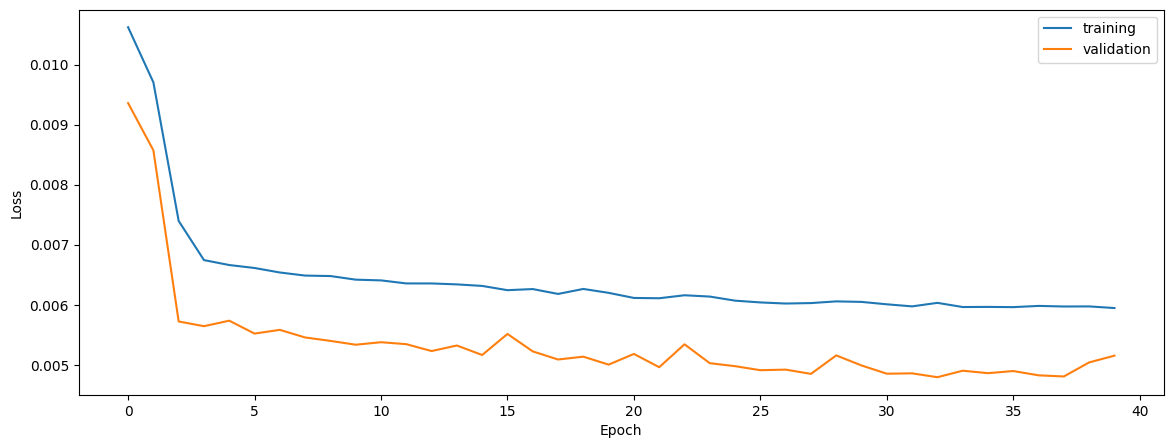

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6314389470012979
0.7014276711702183
0.6224097860090806


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.6314389470012979
0.7014276711702183
0.6224097860090806


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.6338521393822635
0.7024924738462265
0.6376756657868602


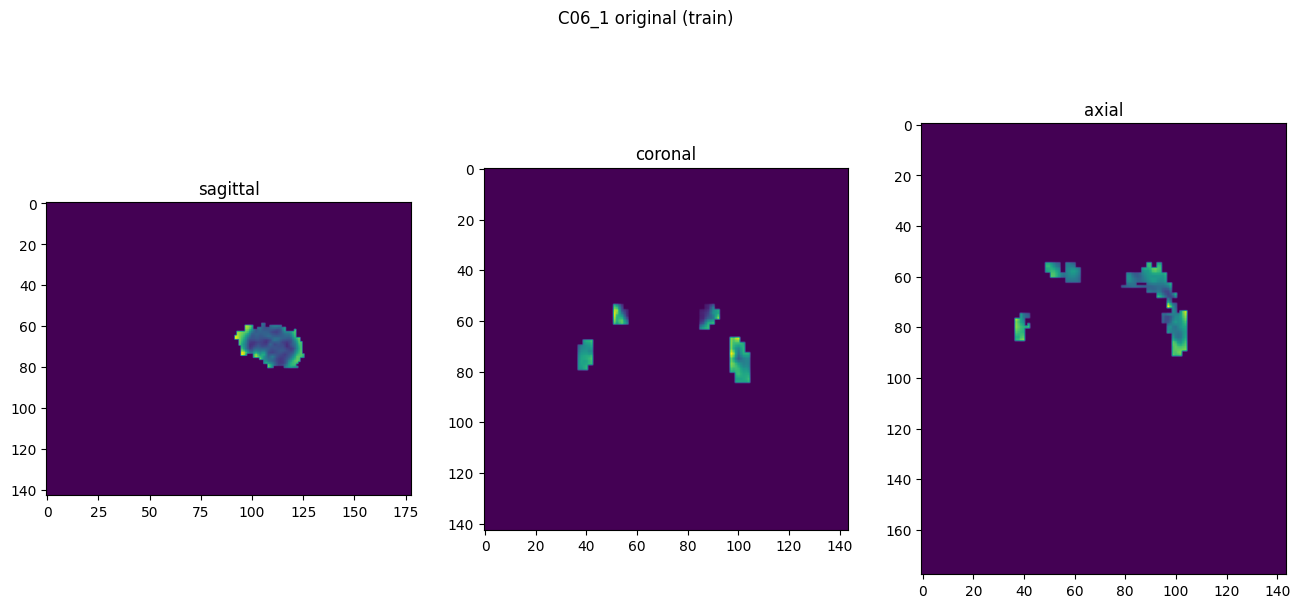

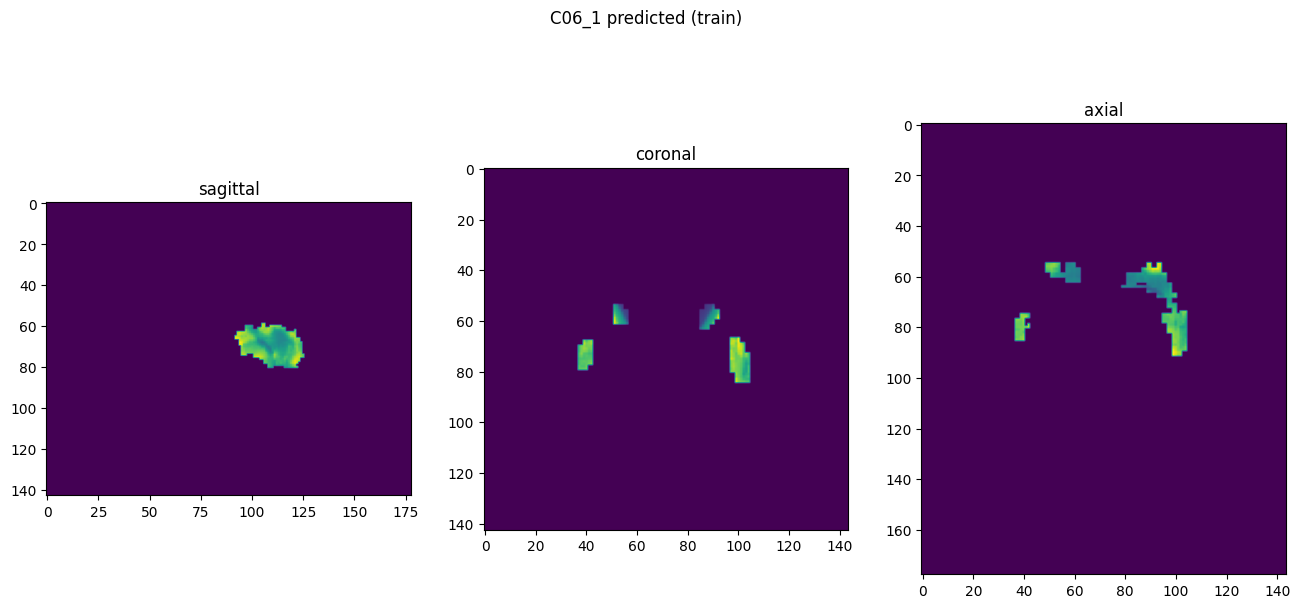

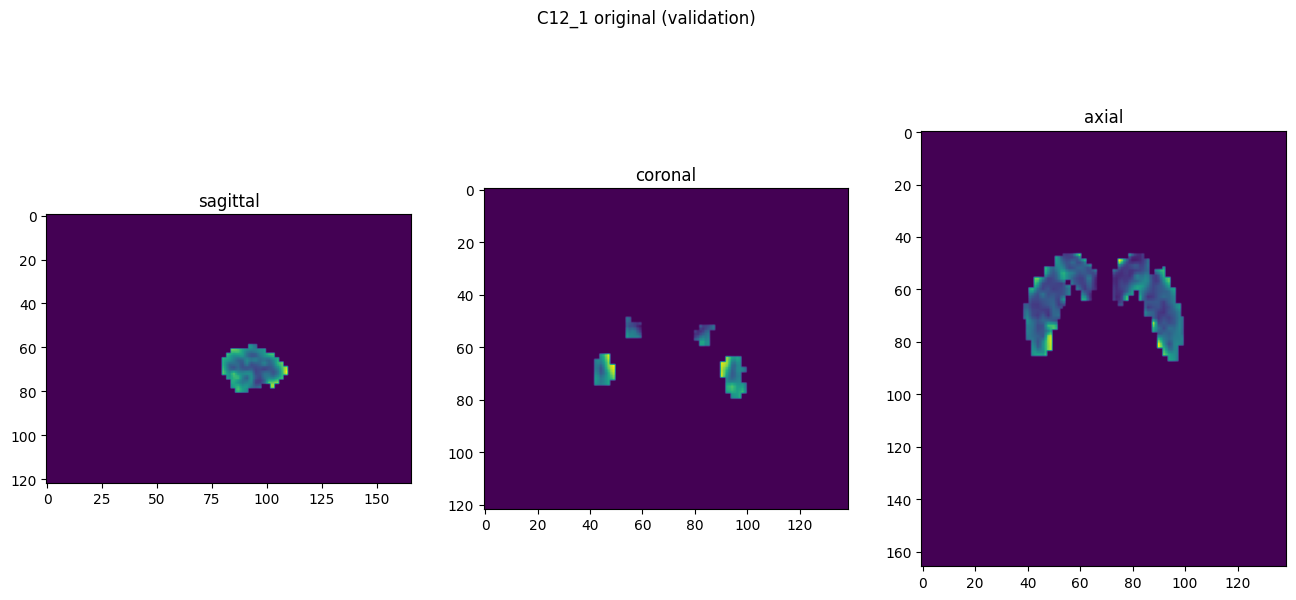

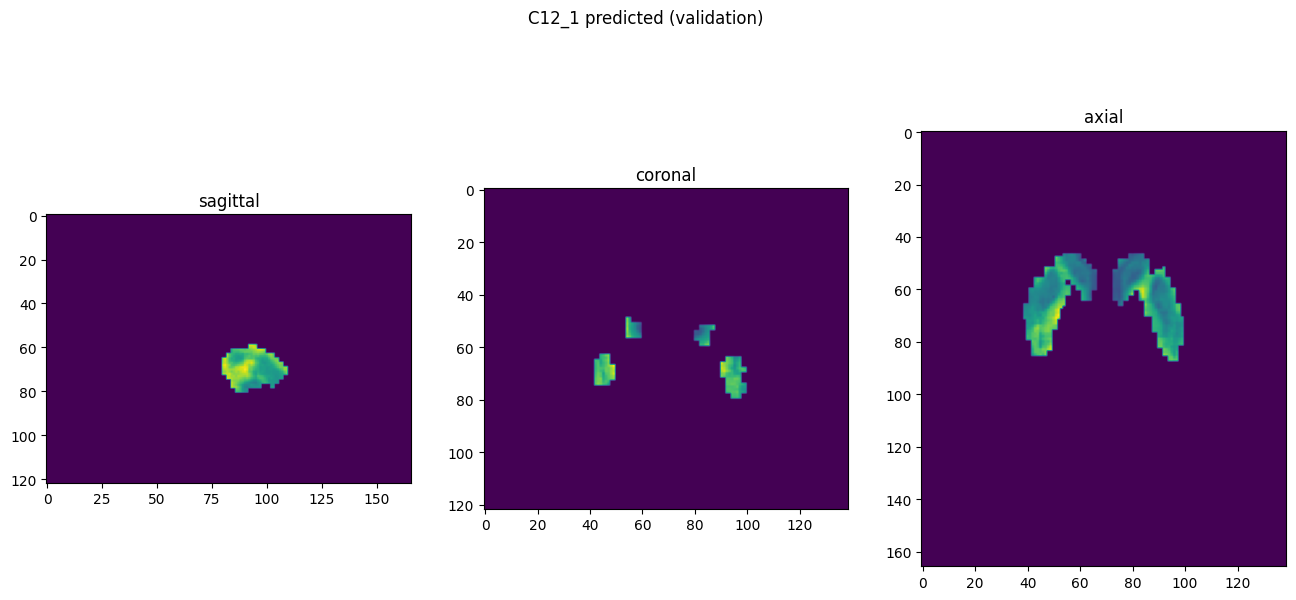

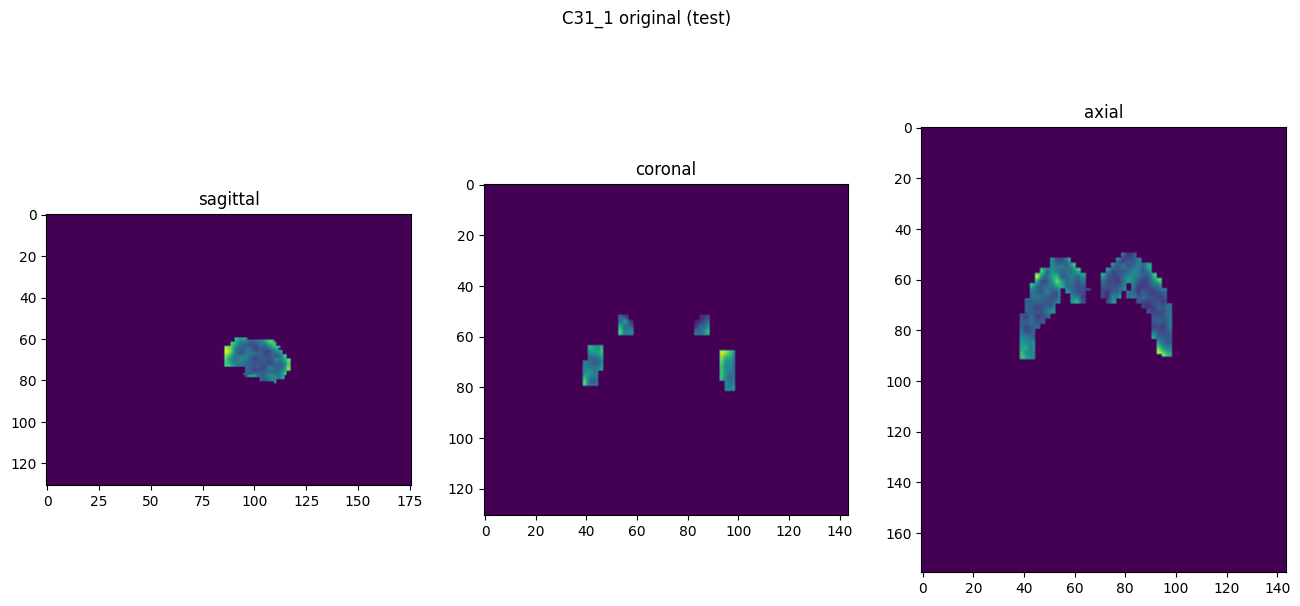

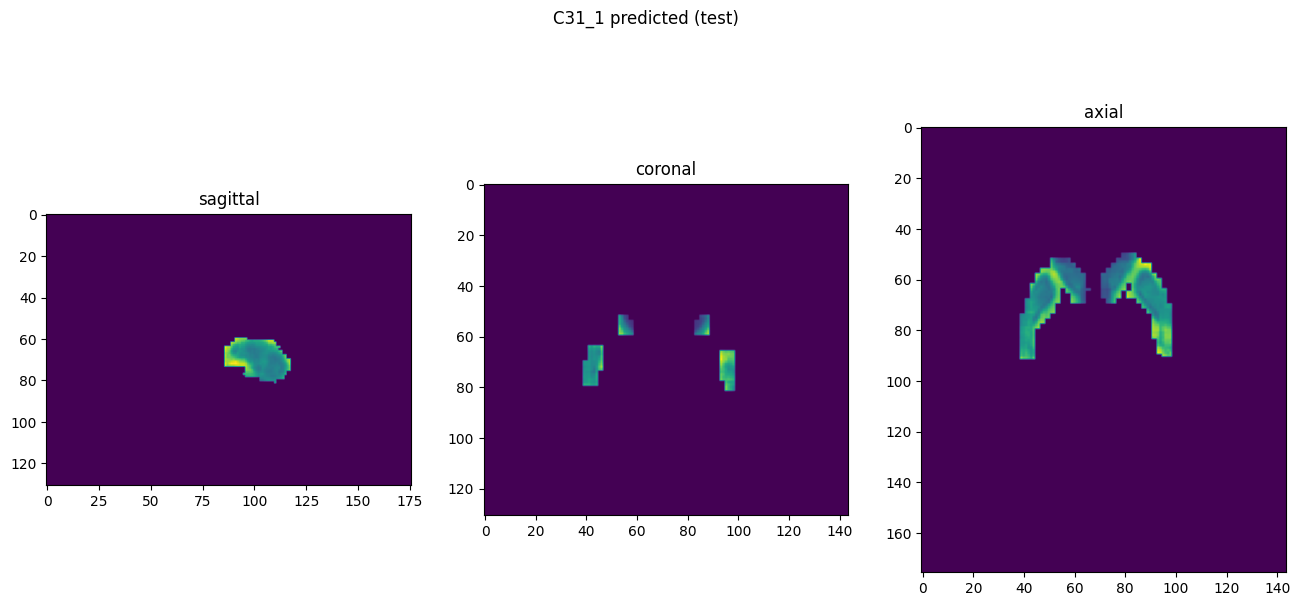

In [10]:
showResults(model, gen, threshold=None, background=False)